# Dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("data/Reviews.csv")

np.random.seed(1)
data = data.iloc[np.random.permutation(len(data))]

# Subset 10000 samples
data = data.iloc[:10000,]

data['Score'].value_counts()

5    6344
4    1420
1     925
3     785
2     526
Name: Score, dtype: int64

In [6]:
def label(row):
    if row['Score'] == 1 or row['Score'] == 2:
        return 'Negative'
    if row['Score'] == 3:
        return 'Neutral'
    return 'Positive'

data['Sentiment'] = data.apply(lambda row: label(row), axis=1)

ns = data.shape[0]
ntr = int(ns * 0.6)
nval = int(ns * 0.2)
nte = ns - ntr - nval

data = data.loc[:, ['Id', 'Sentiment', 'Text']]

data_tr = data.iloc[:ntr, :]
data_val = data.iloc[ntr:ntr+nval, :]
data_te = data.iloc[ntr+nval:, :]

data_tr.Sentiment.value_counts()

Positive    4662
Negative     870
Neutral      468
Name: Sentiment, dtype: int64

In [7]:
data_val.Sentiment.value_counts()

Positive    1568
Negative     269
Neutral      163
Name: Sentiment, dtype: int64

In [9]:
data_te.Sentiment.value_counts()

Positive    1534
Negative     312
Neutral      154
Name: Sentiment, dtype: int64

# Clustering

## Vectorise text

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# create TF-IDF vectorizer
tfidf = TfidfVectorizer()

# fit vectorizer on text data
tfidf.fit(data['Text'])

# transform text data into TF-IDF vectors
X = tfidf.transform(data['Text'])

In [13]:
X_tr = X[:ntr, :]
X_val = X[ntr:ntr+nval, :]
X_te = X[ntr+nval:, :]

In [14]:
feature_names = tfidf.get_feature_names_out()

In [15]:
class KMeans:
    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for i in range(self.max_iter):
            distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            labels = np.argmin(distances, axis=0)
            for j in range(self.n_clusters):
                if np.any(labels == j):
                    self.centroids[j] = X[labels == j].mean(axis=0)

    def predict(self, X):
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        return labels

In [16]:
X_tr = X_tr.toarray()

In [17]:
X_val = X_val.toarray()

In [18]:
X_te = X_te.toarray()

In [19]:
# Generate some sample data
# X = np.random.randn(100, 3)

# Create a KMeans object and fit the data
kmeans = KMeans(n_clusters=5, max_iter=10)
kmeans.fit(X_tr)

In [20]:
# Predict the cluster labels for the data
labels = kmeans.predict(X_tr)

# Plot the data with different colors for each cluster
# plt.scatter(X[:, 0], X[:, 1], c=labels)
# plt.show()

In [23]:
data_tr.iloc[labels==0,2].values[:2]

array(["my girls absolutely loved this tuna. they were in heaven and couldn't get enough of this tasty treat. A bit pricey since I do have 4 cats and the pack went super fast giving each of them a treat",
       'I have pretty much tried them all. The dark chocolate and fruit mix are perfect. This should be considered a drug.....;)'],
      dtype=object)

In [24]:
data_tr.iloc[labels==1,2].values[:2]

array(['I love the Cherry Pie Lara bar.  Best and tasty bar for when my sugar is low.  I recomend this Bar for diabetics low sugar only, as the carbs are about 30 for the bar.',
       'This was just the basic ingredients that i could have found at the local harris teeter, but this kit had everything i needed to get me started making sushi.'],
      dtype=object)

In [25]:
data_tr.iloc[labels==2,2].values[:2]

array(['Melitta Cafe COllection Blanc et Noir coffee has a very smooth, refined armoma you notice as soon as you open up the package. That same aroma translates well throughout the brewing process and remains once poured into your cup. Once you taste it, you will find that the flavor is bold yet smooth, it has a slightly dark, powerful flavor without any of the coarseness or bitterness. I went directly from one of those high-pressure coffee pod brewing systems to using the Melitta in a percolator, and it seems Melitta has helped me find my way back to a better cup of coffee.',
       'Made this coffee with a percolator maybe that is the wrong method but it cannot compare in taste to my regular coffee.  Will not buy it again.'],
      dtype=object)

In [26]:
data_tr.iloc[labels==3,2].values[:2]

array(['UPDATE - 8/9/2010<br />A lot can happen in just a couple months, the last two cases of these I have ordered from Amazon have been horrible.  I\'ve had whole artichoke leaves in several cans (not the small soft leaves near the heart, I\'m talking the big tough artichoke leaves). Brown spots over many of the artichokes.  Very poor quality.<br /><br />I contacted Amazon both times, the first time they replaced the case and the quality was much better.  The second time I asked them for a refund because two times in a couple months is not acceptable. I also contacted Reese direcly who doubted me and asked me to "prove it" by sending them two cans at my expense. I told them I\'d gladly send them all the cans at their expense, but they would not do that. My impression of Reese has changed very much and I will no longer buy their products.<br /><br />ORIGINAL REVIEW - I\'ve tried just about every brand out there and Reese, by far, is the best!  I love that you can buy them already quar

In [27]:
data_tr.iloc[labels==4,2].values[:2]

array(['The vendor is fast and dependable. The tea is simply the best way to relax and great tasting too. Highly recommend !!',
       "This is a good tasting tea at a great price. If you don't normally like raspberry flavor, this isn't really raspberry flavor, if that makes sense. No heavy flavor."],
      dtype=object)

In [64]:
for k in range(5):
    print("\nCluster: %d" % k)
    tfidf_matrix = X_tr[labels==k]

    # calculate the magnitude of each vector
    vector_magnitudes = np.linalg.norm(tfidf_matrix, axis=1)

    # get the indices of the top 5 vectors with highest magnitude
    top_indices = np.argsort(vector_magnitudes)[::-1][:5]

    # get the TF-IDF vectors for the top 5 indices
    top_vectors = [tfidf_matrix[i, :] for i in top_indices]

    # convert each vector to a dictionary with feature names as keys
    # and TF-IDF values as values
    top_dicts = [{feature_names[j]: top_vectors[i][j] for j in range(len(feature_names))}
                 for i in range(len(top_vectors))]

    # sort the dictionaries in descending order of TF-IDF values
    for d in top_dicts:
        sorted_items = sorted(d.items(), key=lambda x: x[1], reverse=True)
        print(sorted_items[:1][0][0])


Cluster: 0
biscotti
north
lunchbag
bahlsen
others

Cluster: 1
grain
vacation
sulfites
latch
we

Cluster: 2
pecan
white
drinker
coffee
coffee

Cluster: 3
matcha
juice
grams
you
gingerbread

Cluster: 4
kombucha
tea
valerian
tea
chinese


In [65]:
pd.crosstab(labels, data_tr.Sentiment.values)

col_0,Negative,Neutral,Positive
row_0,,,
0,199,101,1218
1,421,207,2084
2,80,49,407
3,135,90,617
4,35,21,336


# Q3: Comparing Classifiers

### Model 1: Dummy Classifier with strategy="most_frequent"

In [77]:
data_tr['Sentiment'].value_counts()
pred_model_1 = np.array(['Positive']*data_val.shape[0])

### Model 2: Dummy Classifier with strategy="stratified"

In [78]:
from sklearn.dummy import DummyClassifier

# Create and fit the DummyClassifier with strategy="stratified"
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_tr, data_tr['Sentiment'].values)

pred_model_2 = dummy.predict(X_val)

### Model 3: LogisticRegression with One-hot vectorization

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Example data
X_train = ['This is a positive review', 
           'This is a negative review', 
           'This is a neutral review']
y_train = ['positive', 'negative', 'neutral']

# Create pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

In [84]:
# Train model
pipeline.fit(data_tr['Text'].values, data_tr['Sentiment'].values)

D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [85]:
# Example predictions
# X_test = ['This is a great product', 'This is a terrible product']
pred_model_3 = pipeline.predict(data_val['Text'].values)

### Model 4: LogisticRegression with TF-IDF vectorization

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# create a logistic regression model
lr = LogisticRegression(random_state=42)

# fit the model to the training data
lr.fit(X_tr, data_tr['Sentiment'].values)

# predict the target variable for the testing data
pred_model_4 = lr.predict(X_val)

### Model 5: SVC Classifier with One-hot vectorization (SVM with RBF kernel, default settings)

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# create CountVectorizer object for one-hot encoding
vectorizer = CountVectorizer()

# create SVC object with RBF kernel and default hyperparameters
clf = SVC(kernel='rbf')

# create pipeline for one-hot encoding and classification
pipe = Pipeline([('vect', vectorizer), ('clf', clf)])

In [88]:
# fit pipeline on training data
pipe.fit(data_tr['Text'].values, data_tr['Sentiment'].values)

# predict on test data
pred_model_5 = pipe.predict(data_val['Text'].values)

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
res = [pred_model_1, pred_model_2, pred_model_3, pred_model_4, pred_model_5]
model_name = ["Model 1: Dummy Classifier with strategy=most_frequent", 
              "Model 2: Dummy Classifier with strategy=stratified", 
              "Model 3: LogisticRegression with One-hot vectorization", 
              "Model 4: LogisticRegression with TF-IDF vectorization", 
              "Model 5: SVC Classifier with One-hot vectorization (SVM with RBF kernel, default settings)"]
for i in range(5):
    print("\n")
    print(model_name[i])
    y_true = data_val['Sentiment'].values
    y_pred = res[i]
    # calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", round(accuracy, 3))
    # calculate macro-averaged precision, recall, and F1
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    print("Macro-averaged Precision:", round(precision, 3))
    print("Macro-averaged Recall:", round(recall, 3))
    print("Macro-averaged F1:", round(f1, 3))



Model 1: Dummy Classifier with strategy=most_frequent
Accuracy: 0.784
Macro-averaged Precision: 0.261
Macro-averaged Recall: 0.333
Macro-averaged F1: 0.293


Model 2: Dummy Classifier with strategy=stratified
Accuracy: 0.633
Macro-averaged Precision: 0.33
Macro-averaged Recall: 0.328
Macro-averaged F1: 0.329


Model 3: LogisticRegression with One-hot vectorization
Accuracy: 0.815
Macro-averaged Precision: 0.58
Macro-averaged Recall: 0.541
Macro-averaged F1: 0.556


Model 4: LogisticRegression with TF-IDF vectorization
Accuracy: 0.822


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro-averaged Precision: 0.678
Macro-averaged Recall: 0.447
Macro-averaged F1: 0.464


Model 5: SVC Classifier with One-hot vectorization (SVM with RBF kernel, default settings)
Accuracy: 0.804
Macro-averaged Precision: 0.536
Macro-averaged Recall: 0.388
Macro-averaged F1: 0.389


In [91]:
from sklearn.metrics import classification_report
y_pred = res[3]
report = classification_report(y_true, y_pred, digits=3)
print(report)

              precision    recall  f1-score   support

    Negative      0.703     0.335     0.453       269
     Neutral      0.500     0.018     0.036       163
    Positive      0.831     0.989     0.903      1568

    accuracy                          0.822      2000
   macro avg      0.678     0.447     0.464      2000
weighted avg      0.787     0.822     0.772      2000



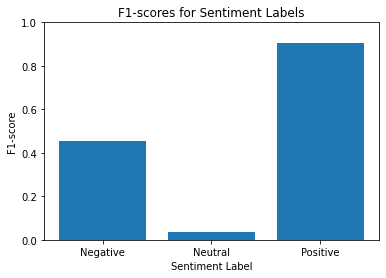

In [92]:
import matplotlib.pyplot as plt

labels = ['Negative', 'Neutral', 'Positive']
f1_scores = [0.453, 0.036, 0.903]

plt.bar(labels, f1_scores)
plt.title('F1-scores for Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('F1-score')
plt.ylim(0, 1)
plt.show()

## Decision Tree

In [195]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [197]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_tr, data_tr['Sentiment'].values)
# Use the classifier to predict labels for the test set
y_pred_dt = clf.predict(X_te)

In [200]:
y_true = data_val['Sentiment'].values
y_pred = y_pred_dt

# calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", round(accuracy, 3))

# calculate macro-averaged precision, recall, and F1
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
print("Macro-averaged Precision:", round(precision, 3))
print("Macro-averaged Recall:", round(recall, 3))
print("Macro-averaged F1:", round(f1, 3))

Accuracy: 0.654
Macro-averaged Precision: 0.324
Macro-averaged Recall: 0.326
Macro-averaged F1: 0.324


# Q4: Parameter Tuning

In [206]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# create instance of TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# fit the vectorizer on training data
tfidf_vectorizer.fit(data_tr['Text'])

TfidfVectorizer()

In [213]:
# transform training and test data
X_train_tfidf = tfidf_vectorizer.transform(data_tr['Text'])
X_val_tfidf = tfidf_vectorizer.transform(data_val['Text'])
X_te_tfidf = tfidf_vectorizer.transform(data_te['Text'])

In [212]:
# create instance of LogisticRegression
clf = LogisticRegression()

# fit the model on training data
clf.fit(X_train_tfidf, data_tr['Sentiment'].values)

# predict on test data
y_pred = clf.predict(X_val_tfidf)

# evaluate performance
accuracy = accuracy_score(data_val['Sentiment'].values, y_pred)
print(f"Accuracy: {accuracy}")

## Grid Search

In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# Define the range of C values to search over
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

In [221]:
param_grid['logisticregression__C']

[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [225]:
for i in range(len(param_grid['logisticregression__C'])):
    param = param_grid['logisticregression__C'][i]
    
    # create instance of LogisticRegression
    clf = LogisticRegression(C=param)

    # fit the model on training data
    clf.fit(X_train_tfidf, data_tr['Sentiment'].values)

    # predict on test data
    y_pred = clf.predict(X_val_tfidf)

    # evaluate performance
    accuracy = accuracy_score(data_val['Sentiment'].values, y_pred)
    print(f"param: {param}; Accuracy: {accuracy}")
    
    y_true = data_val['Sentiment'].values

    # calculate accuracy

    # calculate macro-averaged precision, recall, and F1
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    
    print("Macro-averaged Precision:", round(precision, 3))
    print("Macro-averaged Recall:", round(recall, 3))
    print("Macro-averaged F1:", round(f1, 3))

param: 0.001; Accuracy: 0.784
Macro-averaged Precision: 0.261
Macro-averaged Recall: 0.333
Macro-averaged F1: 0.293


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


param: 0.01; Accuracy: 0.784
Macro-averaged Precision: 0.261
Macro-averaged Recall: 0.333
Macro-averaged F1: 0.293


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


param: 0.1; Accuracy: 0.7845
Macro-averaged Precision: 0.595
Macro-averaged Recall: 0.335
Macro-averaged F1: 0.296


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


param: 1; Accuracy: 0.823
Macro-averaged Precision: 0.701
Macro-averaged Recall: 0.455
Macro-averaged F1: 0.473


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param: 10; Accuracy: 0.836
Macro-averaged Precision: 0.644
Macro-averaged Recall: 0.538
Macro-averaged F1: 0.564


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param: 100; Accuracy: 0.8255
Macro-averaged Precision: 0.602
Macro-averaged Recall: 0.547
Macro-averaged F1: 0.565


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param: 1000; Accuracy: 0.82
Macro-averaged Precision: 0.595
Macro-averaged Recall: 0.551
Macro-averaged F1: 0.566
param: 10000; Accuracy: 0.8205
Macro-averaged Precision: 0.599
Macro-averaged Recall: 0.555
Macro-averaged F1: 0.57


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_features=1000)

In [227]:
for sublinear_tf in [True, False]:
    for max_features in [None, 1000, 10000, 50000]:
        # transform training and test data
        tfidf_vectorizer = TfidfVectorizer(sublinear_tf=sublinear_tf, 
                                           max_features=max_features)
        tfidf_vectorizer.fit(data_tr['Text'])
        X_train_tfidf = tfidf_vectorizer.transform(data_tr['Text'])
        X_val_tfidf = tfidf_vectorizer.transform(data_val['Text'])
        X_te_tfidf = tfidf_vectorizer.transform(data_te['Text'])

        # create instance of LogisticRegression
        clf = LogisticRegression(C=10)

        # fit the model on training data
        clf.fit(X_train_tfidf, data_tr['Sentiment'].values)

        # predict on test data
        y_pred = clf.predict(X_val_tfidf)

        # evaluate performance
        accuracy = accuracy_score(data_val['Sentiment'].values, y_pred)
        print(f"sublinear_tf: {sublinear_tf}; max_features: {max_features}; Accuracy: {accuracy}")

        y_true = data_val['Sentiment'].values

        # calculate macro-averaged precision, recall, and F1
        precision = precision_score(y_true, y_pred, average="macro")
        recall = recall_score(y_true, y_pred, average="macro")
        f1 = f1_score(y_true, y_pred, average="macro")

        print("Macro-averaged Precision:", round(precision, 3))
        print("Macro-averaged Recall:", round(recall, 3))
        print("Macro-averaged F1:", round(f1, 3))

D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sublinear_tf: True; max_features: None; Accuracy: 0.8345
Macro-averaged Precision: 0.632
Macro-averaged Recall: 0.53
Macro-averaged F1: 0.554


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sublinear_tf: True; max_features: 1000; Accuracy: 0.813
Macro-averaged Precision: 0.589
Macro-averaged Recall: 0.541
Macro-averaged F1: 0.557


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sublinear_tf: True; max_features: 10000; Accuracy: 0.833
Macro-averaged Precision: 0.629
Macro-averaged Recall: 0.527
Macro-averaged F1: 0.551


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sublinear_tf: True; max_features: 50000; Accuracy: 0.8345
Macro-averaged Precision: 0.632
Macro-averaged Recall: 0.53
Macro-averaged F1: 0.554


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sublinear_tf: False; max_features: None; Accuracy: 0.836
Macro-averaged Precision: 0.644
Macro-averaged Recall: 0.538
Macro-averaged F1: 0.564


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sublinear_tf: False; max_features: 1000; Accuracy: 0.8095
Macro-averaged Precision: 0.584
Macro-averaged Recall: 0.532
Macro-averaged F1: 0.55


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sublinear_tf: False; max_features: 10000; Accuracy: 0.8345
Macro-averaged Precision: 0.636
Macro-averaged Recall: 0.536
Macro-averaged F1: 0.563
sublinear_tf: False; max_features: 50000; Accuracy: 0.836
Macro-averaged Precision: 0.644
Macro-averaged Recall: 0.538
Macro-averaged F1: 0.564


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Q5 Context vectors using BERT

In [5]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [11]:
# Load the RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## limit number of words

In [30]:
# define a lambda function to limit the number of words in a text
limit_words = lambda text: ' '.join(text.split()[:200])

# apply the lambda function to the "Text" column of the dataframe
data_tr['Text'] = data_tr['Text'].apply(limit_words)

C:\Users\syx\AppData\Local\Temp/ipykernel_14812/795350021.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr['Text'] = data_tr['Text'].apply(limit_words)


In [36]:
data_val['Text'] = data_val['Text'].apply(limit_words)

C:\Users\syx\AppData\Local\Temp/ipykernel_14812/620808560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['Text'] = data_val['Text'].apply(limit_words)


In [37]:
data_te['Text'] = data_te['Text'].apply(limit_words)

C:\Users\syx\AppData\Local\Temp/ipykernel_14812/1655369468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_te['Text'] = data_te['Text'].apply(limit_words)


In [32]:
feature_tr = np.zeros((data_tr.shape[0], 768))
for i in range(data_tr.shape[0]):
    if i % 100 == 0:
        print(i)
    feature_tr[i, :] = np.array(feature_extraction(data_tr.iloc[i, :]['Text'])[0][0])

In [ ]:
feature_val = np.zeros((data_val.shape[0], 768))

for i in range(data_val.shape[0]):
    if i % 100 == 0:
        print(i)
    feature_val[i, :] = np.array(feature_extraction(data_val.iloc[i, :]['Text'])[0][0])

In [ ]:
feature_te = np.zeros((data_te.shape[0], 768))

for i in range(data_te.shape[0]):
    if i % 100 == 0:
        print(i)
    feature_te[i, :] = np.array(feature_extraction(data_te.iloc[i, :]['Text'])[0][0])

In [41]:
# np.savetxt("feature_tr.txt", feature_tr)
# np.savetxt("feature_val.txt", feature_val)
# np.savetxt("feature_te.txt", feature_te)

In [30]:
feature_tr = np.loadtxt("feature_tr.txt")
feature_val = np.loadtxt("feature_val.txt")
feature_te = np.loadtxt("feature_te.txt")
# np.savetxt("feature_val.txt", feature_val)
# np.savetxt("feature_te.txt", feature_te)

## Part a

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# create a logistic regression model
lr = LogisticRegression(random_state=42)

# fit the model to the training data
lr.fit(feature_tr, data_tr['Sentiment'].values)

# predict the target variable for the testing data
pred_lr = lr.predict(feature_val)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = data_val['Sentiment'].values
y_pred = pred_lr

# calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", round(accuracy, 3))

# calculate macro-averaged precision, recall, and F1
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
print("Macro-averaged Precision:", round(precision, 3))
print("Macro-averaged Recall:", round(recall, 3))
print("Macro-averaged F1:", round(f1, 3))


Accuracy: 0.849
Macro-averaged Precision: 0.661
Macro-averaged Recall: 0.553
Macro-averaged F1: 0.562


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## part b

In [27]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd
import torch

In [8]:
data_tr = data_tr.reset_index()
data_te = data_te.reset_index()
data_val = data_val.reset_index()

In [9]:
from sklearn.preprocessing import LabelEncoder

# create a label encoder object
label_encoder = LabelEncoder()
label_encoder.fit(data_tr['Sentiment'])

LabelEncoder()

In [10]:
# fit and transform the labels column to integers
data_tr['label_int'] = label_encoder.transform(data_tr['Sentiment'])
data_te['label_int'] = label_encoder.transform(data_te['Sentiment'])
data_val['label_int'] = label_encoder.transform(data_val['Sentiment'])
train_texts = data_tr['Text']
train_labels = data_tr['label_int']
val_texts = data_val['Text']
val_labels = data_val['label_int']
te_texts = data_te['Text']
te_labels = data_te['label_int']

In [11]:
# # Load the Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [12]:
# # Encode the train and validation texts using the tokenizer
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
te_encodings = tokenizer(list(te_texts), truncation=True, padding=True)

In [13]:
# Convert the labels to a list of integers
train_labels = list(train_labels)
val_labels = list(val_labels)
te_labels = list(te_labels)

In [22]:
# Create a PyTorch dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], device='cpu') for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], device='cpu')
        return item

    def __len__(self):
        return len(self.labels)

In [23]:
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
te_dataset = CustomDataset(te_encodings, te_labels)

In [ ]:
# Load the Roberta model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

In [25]:
model = model.to('cpu')

In [ ]:
# Set the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=4,   # batch size for evaluation
    learning_rate=1e-4,              # learning rate
    weight_decay=0,                  # weight decay
    evaluation_strategy='epoch',     # evaluation strategy to adopt during training
    disable_tqdm=False,              # disable tqdm progress bar
)

# Create a trainer instance and train the model
trainer = Trainer(
    model=model,
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,     # training dataset
    eval_dataset=val_dataset         # evaluation dataset
)

In [ ]:
trainer.train()

In [ ]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate(eval_dataset=val_dataset)
print(eval_results)

# Q6 Conclusions and Future work

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# create a logistic regression model
lr = LogisticRegression(random_state=42)

# fit the model to the training data
lr.fit(feature_tr, data_tr['Sentiment'].values)

# predict the target variable for the testing data
pred_lr = lr.predict(feature_te)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = data_te['Sentiment'].values
y_pred = pred_lr

# calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", round(accuracy, 3))

# calculate macro-averaged precision, recall, and F1
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
print("Macro-averaged Precision:", round(precision, 3))
print("Macro-averaged Recall:", round(recall, 3))
print("Macro-averaged F1:", round(f1, 3))

Accuracy: 0.856
Macro-averaged Precision: 0.736
Macro-averaged Recall: 0.561
Macro-averaged F1: 0.576


D:\software\anaconda\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
from sklearn.metrics import confusion_matrix

# create confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

[[ 199    3  110]
 [  41   10  103]
 [  27    4 1503]]
